In [23]:
# Import necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import warnings

warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

# Preprocessing

In [24]:
# Load data
df = pd.read_csv("train.csv")

In [25]:
# Data Overview and Null Check
print("Dataset Overview:")
display(df.head())
print("\nNull Values in Each Column:")
display(df.isnull().sum())

Dataset Overview:


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,DRIRC89L0T,18,137576,209136,846,26,2,10.47,60,0.81,High School,Self-employed,Single,Yes,No,Business,No,0
1,TS0FIUNHNU,47,57194,5970,748,30,2,19.72,36,0.73,High School,Unemployed,Divorced,No,Yes,Education,No,0
2,I0YR284A1V,26,84328,95065,453,7,2,24.25,12,0.45,Master's,Self-employed,Married,No,No,Other,Yes,0
3,WB1T7NQV8A,53,49795,229582,533,107,3,14.44,60,0.17,Bachelor's,Self-employed,Single,Yes,No,Auto,Yes,1
4,J6GU9M4G1Z,49,115450,22072,840,0,4,24.48,12,0.11,Bachelor's,Part-time,Single,No,Yes,Education,Yes,0



Null Values in Each Column:


LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64

In [26]:
# Drop unnecessary columns
df.drop(columns=["LoanID", "LoanTerm"], inplace=True)

In [27]:
# Encoding categorical variables
categorical_columns = ['Education', 'EmploymentType', 'MaritalStatus', 
                       'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']
label_encoder = LabelEncoder()

for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

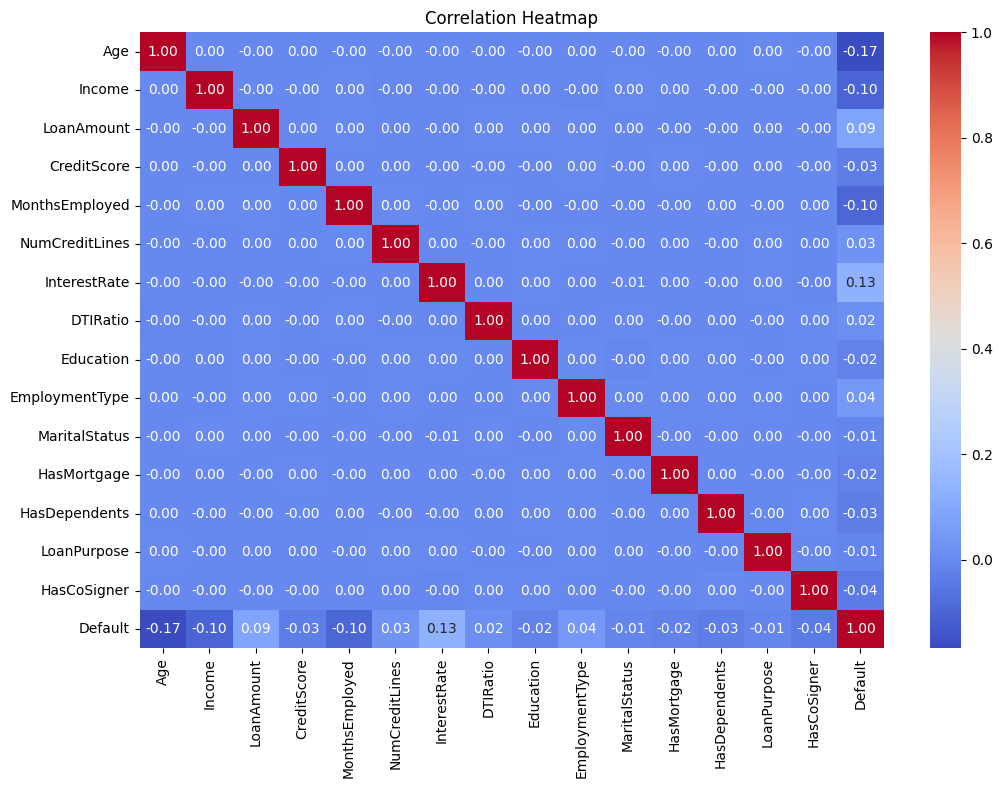

In [28]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

In [29]:
# Normalize data
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df)
df = pd.DataFrame(normalized_data, columns=df.columns)

In [30]:
# Target and features split
X = df.drop('Default', axis=1)
y = df['Default']

In [31]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Handle imbalance using SMOTE
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

## Decision Tree

In [ ]:
# Model Training and Evaluation: Decision Tree with GridSearchCV
print("\nDecision Tree Classifier with Grid Search")
d_tree = DecisionTreeClassifier(random_state=42)
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}
grid_search = GridSearchCV(estimator=d_tree, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_smote, y_train_smote)


Decision Tree Classifier with Grid Search
Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [ ]:
# Evaluate Decision Tree
best_dtree_model = grid_search.best_estimator_
y_pred_dtree = best_dtree_model.predict(X_test)
acc_dtree = accuracy_score(y_test, y_pred_dtree)
print(f"Decision Tree Accuracy: {acc_dtree:.2f}")
print(classification_report(y_test, y_pred_dtree))

## Random Forest

In [ ]:
# Model Training and Evaluation: Random Forest
print("\nRandom Forest Classifier")
model_RF = RandomForestClassifier(
    n_estimators=100, max_depth=50, min_samples_split=5, min_samples_leaf=1, 
    bootstrap=True, random_state=42)
model_RF.fit(X_train_smote, y_train_smote)
y_pred_rf = model_RF.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {acc_rf:.2f}")
print(classification_report(y_test, y_pred_rf))

## Xgboost

In [33]:
# Model Training and Evaluation: Gradient Boosting Classifier
print("\nGradient Boosting Classifier")
gb_model = GradientBoostingClassifier(
    random_state=42, n_estimators=150, learning_rate=0.1, max_depth=3, 
    min_samples_split=3, min_samples_leaf=3, subsample=0.8, max_features='sqrt')
gb_model.fit(X_train_smote, y_train_smote)
gb_predictions = gb_model.predict(X_test)
acc_gb = accuracy_score(y_test, gb_predictions)
print(f"Gradient Boosting Accuracy: {acc_gb:.2f}")
print(classification_report(y_test, gb_predictions))


Gradient Boosting Classifier
Gradient Boosting Accuracy: 0.83
              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90     36073
         1.0       0.31      0.37      0.34      4783

    accuracy                           0.83     40856
   macro avg       0.61      0.63      0.62     40856
weighted avg       0.84      0.83      0.83     40856



In [34]:
# Load and preprocess test data for final prediction
test_data = pd.read_csv('test.csv')
Loan_IDs = test_data['LoanID'].copy()
test_data.drop(columns=["LoanID", "LoanTerm"], inplace=True)

In [35]:
# Encoding categorical features in test data
from sklearn.preprocessing import LabelEncoder
categorical_columns = ['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']
label_encoder = LabelEncoder()
for col in categorical_columns:
    test_data[col] = label_encoder.fit_transform(test_data[col])

In [36]:
# Normalize test data
min_max_scaler = MinMaxScaler()
normalized_data = min_max_scaler.fit_transform( test_data)
test_data=pd.DataFrame(normalized_data, columns= test_data.columns)
test_data

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner
0,0.725490,0.723410,0.356727,0.511840,0.949580,0.333333,0.936522,0.0625,1.000000,0.666667,1.0,1.0,1.0,0.75,0.0
1,0.745098,0.567203,0.516662,0.621129,0.453782,0.000000,0.573478,0.4125,0.333333,0.333333,0.0,1.0,1.0,0.50,1.0
2,0.156863,0.467939,0.287433,0.489982,0.882353,0.666667,0.696522,0.2375,0.666667,0.333333,0.5,1.0,1.0,0.50,1.0
3,0.156863,0.355816,0.023691,0.047359,0.991597,0.000000,0.552609,0.3875,0.333333,0.333333,1.0,0.0,0.0,0.25,1.0
4,0.117647,0.108634,0.066053,0.659381,0.857143,0.666667,0.566087,0.7375,1.000000,1.000000,1.0,0.0,1.0,0.25,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51065,0.647059,0.625754,0.674949,0.597450,0.201681,0.000000,0.653478,0.4500,1.000000,0.666667,0.0,1.0,1.0,0.00,1.0
51066,0.215686,0.200127,0.433959,0.129326,0.428571,1.000000,0.221739,0.5000,1.000000,0.666667,0.5,0.0,0.0,1.00,0.0
51067,0.960784,0.544520,0.561934,0.785064,0.428571,0.000000,0.908261,0.8625,0.000000,0.333333,0.0,0.0,0.0,0.50,0.0
51068,0.470588,0.752989,0.758974,0.342441,0.050420,0.000000,0.383913,0.2750,0.000000,0.000000,0.5,0.0,1.0,1.00,1.0


In [37]:
# Final predictions using Gradient Boosting model
final_predictions = gb_model.predict(test_data)

In [38]:
# Prepare submission file
output = pd.DataFrame({
    'LoanID': Loan_IDs,
    'Default': final_predictions
})
output.to_csv('final_predictions.csv', index=False)